In [1]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_palette(sns.color_palette("pastel"))

In [3]:
df = pd.read_csv("../data/Spaceship Titanic/train.csv")

In [4]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
missing = df.isna().mean()
for name, percentage in missing.items():
    print("{} is missing {}%".format(name, round(percentage, 3)))

PassengerId is missing 0.0%
HomePlanet is missing 0.023%
CryoSleep is missing 0.025%
Cabin is missing 0.023%
Destination is missing 0.021%
Age is missing 0.021%
VIP is missing 0.023%
RoomService is missing 0.021%
FoodCourt is missing 0.021%
ShoppingMall is missing 0.024%
Spa is missing 0.021%
VRDeck is missing 0.022%
Name is missing 0.023%
Transported is missing 0.0%


In [6]:
imputer = SimpleImputer(strategy="most_frequent")

In [7]:
cabin = imputer.fit_transform(df[["Cabin"]])

In [8]:
df["Cabin_replaced"] = [x[0][0] for x in cabin]

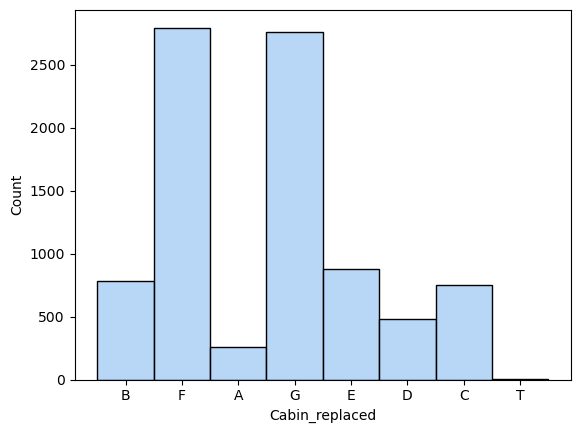

In [9]:
sns.histplot(data=df, x="Cabin_replaced");

In [10]:
df.drop(["Name", "Cabin", "PassengerId"], axis=1, inplace=True)

In [11]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_replaced
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F


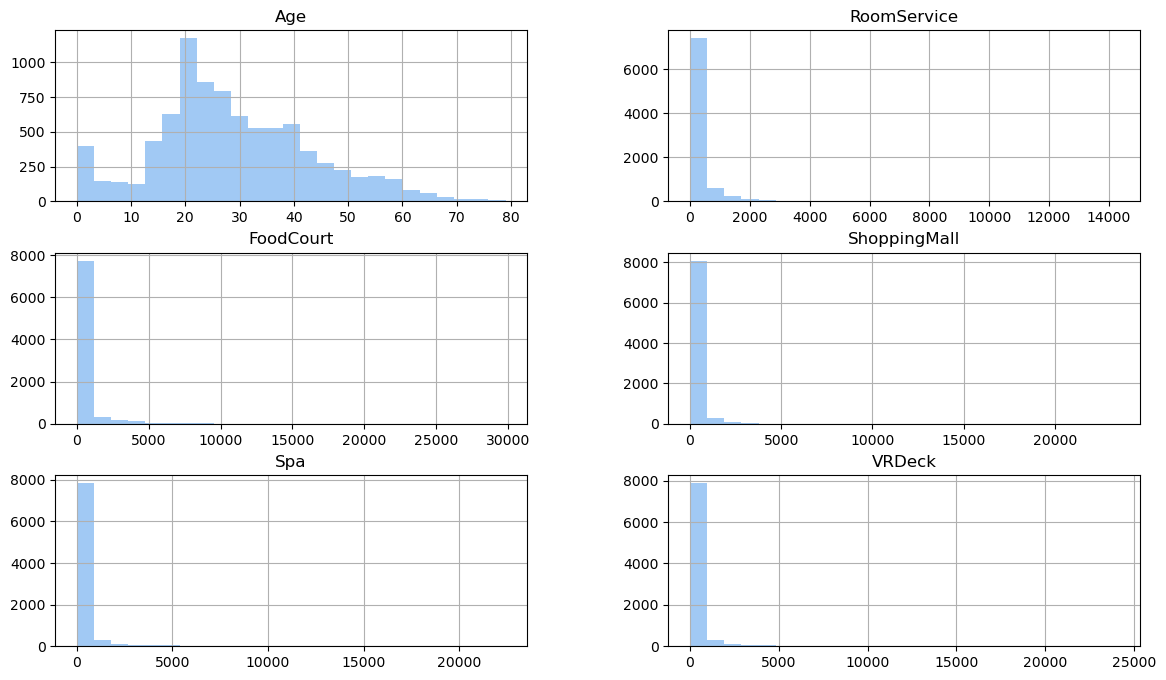

In [12]:
missing_labels = [label for label, content in df.items() if content.isna().sum() > 1 ]
df[missing_labels].hist(bins=25, figsize=(14, 8));

In [13]:
X = df.drop("Transported", axis=1)
y = df["Transported"]

In [14]:
cat_features = [c for c in X.columns if X[c].dtype == "O"]
num_features = [c for c in X.columns if X[c].dtype != "O"]

In [15]:
X[cat_features].head()

,HomePlanet,CryoSleep,Destination,VIP,Cabin_replaced
0,Europa,False,TRAPPIST-1e,False,B
1,Earth,False,TRAPPIST-1e,False,F
2,Europa,False,TRAPPIST-1e,True,A
3,Europa,False,TRAPPIST-1e,False,A
4,Earth,False,TRAPPIST-1e,False,F


In [16]:
X[num_features].head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, y_train.shape

((6085, 11), (6085,))

In [34]:
X_train.dtypes

HomePlanet         object
CryoSleep          object
Destination        object
Age               float64
VIP                object
RoomService       float64
FoodCourt         float64
ShoppingMall      float64
Spa               float64
VRDeck            float64
Cabin_replaced     object
dtype: object

In [35]:
num_imputer = make_pipeline((SimpleImputer(strategy="median")), (StandardScaler()))
cat_imputer = make_pipeline((SimpleImputer(strategy="constant", fill_value="missing")), (OneHotEncoder(handle_unknown="ignore")))

In [36]:
preprocessor = make_column_transformer((num_imputer, num_features), (cat_imputer, cat_features), remainder="passthrough")

In [37]:
clf = make_pipeline((preprocessor), (CatBoostClassifier()))

In [38]:
clf.fit(X_train, y_train)

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['bool', 'str']